![Banner](images/banner.jpeg)

# AutoML Competitions: a Meta-Learning Perspective

**Anonymous authors**

This notebook contains all experiments and plots presented in the paper "AutoML Competitions: a Meta-Learning Perspective" submitted to [AutoML-Conf 2022](https://automl.cc/).

Automated Machine Learning (AutoML) competitions seek to uncover best solutions to multiple tasks, which might generalize to similar tasks, without human intervention: a meta-learning problem. By casting the problem of judging such competitions as a meta-learning problem, this paper provide a theoretical analysis, which outlines the danger of over-fitting the tasks of a competition. Such (meta-)over-fitting worsens as the number 𝑛 of competition participants increases. We propose a simple scheme to choose the winner, which alleviates this problem, in two-phase competitions having an identical number of similar tasks: the top-k algorithm.

In this notebook, we evaluate the top-k algorithm in various settings: on artificial data and on real data.

**Notebook outline:**

**[1. Artificial / theoretical case](#part1)**

**[2. Real data](#part2)**
- [2.1. One task case](#partA)
- [2.2. Multi-task (AutoML) case](#partB)

In [1]:
import os
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from math import comb, factorial # combination (binomial coefficient) and factorial function
from numpy.linalg.linalg import matrix_power # matrix power (Chapman-Kolmogorov equation)
import sys
sys.path.append('../ranky')
import ranky as rk # select_k_best is implemented in Ranky (https://github.com/didayolo/ranky)

%load_ext autoreload
%autoreload 2

<a id='part1'></a>
# 1. Artificial / theoretical case

Two rankings D and F (representing developmment and final leaderboards) are generated by applying $s$ random swaps on a ground truth ranking $g = [1, 2, ..., n]$.

### acc(k=1) = acc(k=n) = ?

Empirical estimation of $acc(k=n)$, the probability that the winner stays in the first position after the $s$ random swaps, as a function of $\phi = \frac{s}{n}$.

### Markov chain approach
We model the movements of a candidate during the swaps using a Markov chain.

We fix the probability of changing state to $p= \frac{2}{n-1}$

In the Markov chain, we have a "hard wall" below 0 so the "walker" will either stay at 0 or move up to 1
(+ another wall above n)

We obtain the probability of going from the position a to the position b after $s$ swaps by modelling our problem using the Chapman-Kolmogorov equation.

![Markov chain scheme](images/markov_chain.png)

with $p = \frac{1}{n-1}$

In [19]:
def transition_matrix(n):
    ''' The transition matrix leads, from any state, to a better position or a worst position with a probability of 1/(n-1)
    
    Examples:
    
                            [[1/2, 1/2, 0],     
    transition_matrix(3) =  [1/2,  0, 1/2],
                            [0,  1/2, 1/2]]
                            
                            [[2/3, 1/3,  0],     
    transition_matrix(4) =  [1/3, 1/3, 1/3],
                            [0,  1/3,  2/3]]
    '''
    if n < 3:
        raise Exception('n must to be > 2')
    p = 1 / (n-1)
    T = []
    first = [0 for _ in range(n)]
    first[0] = 1 - p
    first[1] = p
    T.append(first)
    for i in range(n-2):
        row = [0 for _ in range(n)]
        row[i] = p
        row[i+1] = 1 - (2*p)
        row[i+2] = p
        T.append(row)
    last = [0 for _ in range(n)]
    last[n-2] = p
    last[n-1] = 1 - p
    T.append(last)    
    return np.array(T)

def proba_move(a, b, n, N):
    ''' Probability of ending up in position b from the starting position a after N swaps, in a list of n elements.
    '''
    T = transition_matrix(n)
    TN = matrix_power(T, N)
    return TN[a][b]

def proba_top_k(a, k, n, N):
    ''' Probability of ending up in positions [0, k] from the starting position a after N moves, in a list of n elements.
    '''
    return np.sum([proba_move(a, b, n, N) for b in range(k)])

Let's compare the empirical probability that the true winner wins to the predicted $acc(k=1)$

In [16]:
# Data points
_phi = []
_pk = []
_markov = []

# Parameters
trials = 10000
_n = [20]
_N = list(range(20*5))

for n in _n:
    for N in tqdm(_N):
        # Artificial judges
        g = rk.generator.SwapGenerator()
        g.fit(list(range(n)))
        # Compute the rank of the true winner
        d = pd.DataFrame(g.sample(N=N, n=trials))
        winner_ranks = d.loc(0)[0]
        pk = winner_ranks.isin([0]).sum(axis=0) / trials
        # Store values
        _phi.append(N/n)
        _pk.append(pk)
        _markov.append(proba_move(0, 0, n, N))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:20<00:00,  2.00s/it]


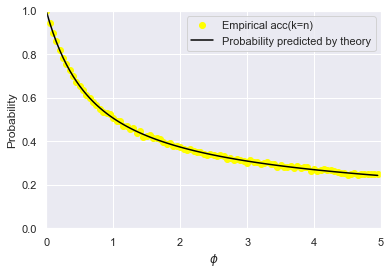

In [18]:
# PLOT
plt.plot(_phi, _pk, 'o', label='Empirical acc(k=n)', color='yellow')
plt.plot(_phi, _markov, '-', label='Probability predicted by theory', color='black')
plt.xlim((0, 5))
plt.ylim((0, 1))
plt.xlabel('$\phi$')
plt.ylabel('Probability')
plt.legend()
plt.show()

# acc(k)

Empirical estimation of $k* = argmax ~ acc(k)$ as a function of $\phi$. 

$k*$ is the optimal argument of select-k-best such that the probability of selecting the winner is maximized.

acc(k) = P(true winner ranked first | true winner in top k) * P(true winner in top k)

To approximate P(tw ranked first | tw in top k), we compute:
- The probability that the true winner ends up first (acc(k=1))
- For each candidates, (1 - P(in top k)) x P(ranked first)

In [20]:
def approx_pk(n, N, k):
    ''' Approximation of acc(k), the probability that the true winner is selected by select-k-best method.
    '''
    prior = proba_top_k(0, k, n, N) # P(true winner in top k)
    pk = proba_move(0, 0, n, N) # # P(k=1) = P(k=n) = proba of winner wining
    for e in range(1, n): # all other candidates
        # P(K) is increased when another candidate would win but is not in topk
        pk += (1 - proba_top_k(e, k, n, N)) * proba_move(e, 0, n, N)   
    return pk * prior

def approx_k_star(n, N):
    return np.argmax([approx_pk(n, N, k) for k in range(n)])

def select_winner(topk, F):
    """ Return the first element from topk in F.
    """
    for e in F:
        if e in topk:
            return e

def evaluate_acc_artificial(n, N, trials=200, return_d=False):
    """ Estimate empirically the accuracy of top-k on artificial data.
    
    If return_d, estimate empirically the average of kendall tau distance between D and F, on artificial data.
    """
    accs = np.zeros(n)
    d = 0
    g = rk.generator.SwapGenerator() # Artificial judges
    g.fit(list(range(n)))
    for _ in range(trials):
        D = g.sample(N=N, n=1)
        F = g.sample(N=N, n=1)
        for k in range(1, n+1):
            winner = select_winner(D[:k], F) # top-k
            if winner == 0: # The selection went well
                accs[k-1] += 1 # count when the true winner wins
        if return_d: # estimation of Kendall tau distance
            d += rk.kendall_tau_distance(D, F, normalize=True)
    if return_d:
        return (accs / trials), (d / trials)
    return (accs / trials)

def evaluate_k_star(n, N, trials=200, return_d=False):
    """ Estimate k* (optimal value of k) empirically on artificial data.
    """
    _k = range(1, n+1)
    if return_d:
        accs, d = evaluate_acc_artificial(n, N, trials=trials, return_d=True)
        return _k[np.argmax(accs)], d
    else:
        accs = evaluate_acc_artificial(n, N, trials=trials)
        return _k[np.argmax(accs)]

def evaluate_d(n, N, trials=200):
    """ OBSOLOTE
    
    Estimate empirically the average of kendall tau distance between D and F, on artificial data.
    """
    g = rk.generator.SwapGenerator()
    g.fit(list(range(n)))
    _d = []
    for _ in range(trials):
        # Artificial judges
        # Compute the rank of the true winner
        D = g.sample(N=N, n=1)
        F = g.sample(N=N, n=1)
        _d.append(rk.kendall_tau_distance(D, F, normalize=True))
    return np.mean(_d)

#### What is the behavior of $k*$ when $\phi$ varies?

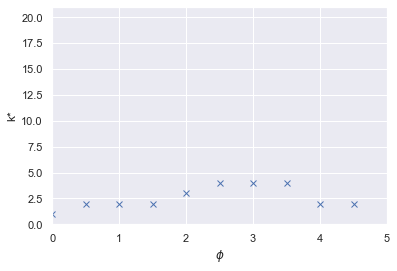

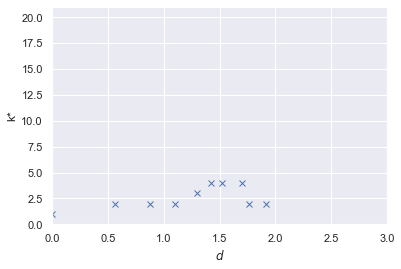

In [65]:
# k*
# Compare k* to phi (and to Kendall distance between D and F)
_phi, _d, _k_star = [], [], []
for n in [20]:
    for N in range(0, 100, 10):
        k_star, d = evaluate_k_star(n, N, trials=100, return_d=True)
        _phi.append(N / n)
        _d.append(d)
        _k_star.append(k_star)

# Plot
plt.plot(_phi, _k_star, 'x')
plt.xlabel('$\phi$')
plt.ylabel('k*')
plt.xlim((0, 5))
plt.ylim((0, n+1))
plt.show()

# Plot
plt.plot(_d, _k_star, 'x')
plt.xlabel('$d$')
plt.ylabel('$k*$')
plt.xlim((0, 3))
plt.ylim((0, n+1))
plt.show()

#### Empirical evaluation of $acc(k)$

-  Evaluate acc(k)
-  TODO: Meta-training / meta-generalization curves for values of k (as for real data)
-  What is meta-train in this case? 

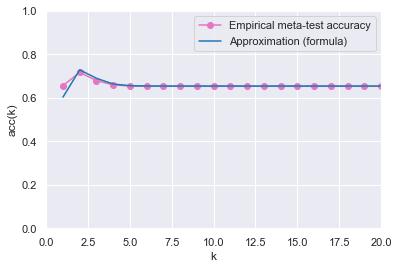

In [21]:
n, N = 20, 10
_k = range(1, n+1)
y = evaluate_acc_artificial(n, N, trials=20000)
y2 = [approx_pk(n, N, k) for k in _k]

# Plot
plt.plot(_k, y, 'o-', label='Empirical meta-test accuracy', color='tab:pink')
plt.plot(_k, y2, '-', label='Approximation (formula)', color='tab:blue')
plt.xlim((0, 20))
plt.ylim((0, 1))
plt.xlabel('k')
plt.ylabel('acc(k)')
plt.legend()
plt.show()

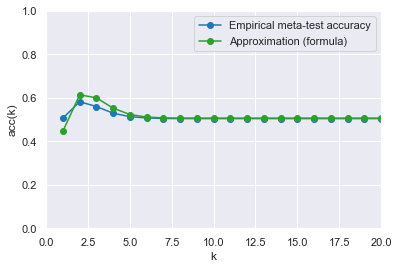

In [22]:
n, N = 20, 20
_k = range(1, n+1)
y = evaluate_acc_artificial(n, N, trials=20000)
y2 = [approx_pk(n, N, k) for k in _k]

# Plot
plt.plot(_k, y, 'o-', label='Empirical meta-test accuracy', color='tab:blue')
plt.plot(_k, y2, 'o-', label='Approximation (formula)', color='tab:green')
plt.xlim((0, 20))
plt.ylim((0, 1))
plt.xlabel('k')
plt.ylabel('acc(k)')
plt.legend()
plt.show()

#### Empirical and predicted $k*$

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:12<00:00,  1.33s/it]


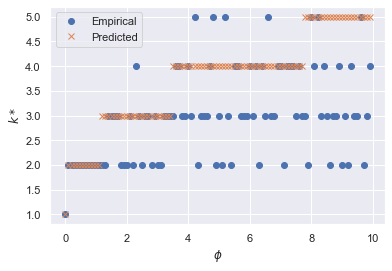

In [22]:
# k*
emp_ks, pre_ks, _phi = [], [], []
n = 10
_N = range(0, 100, 1)
for N in tqdm(_N):
    emp_ks.append(evaluate_k_star(n, N, trials=1000))
    pre_ks.append(approx_k_star(n, N))
    _phi.append(N / n)

# Plot
plt.plot(_phi, emp_ks, 'o', label='Empirical')
plt.plot(_phi, pre_ks, 'x', label='Predicted')
plt.xlabel('$\phi$')
plt.ylabel('$k*$')
plt.legend()
plt.show()

#### $\phi$ vs $d$

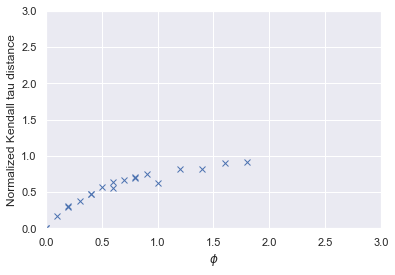

In [47]:
# Compare phi and Kendall distance
_phi, _d = [], []
for n in [5, 10]:
    for N in range(10):
        _phi.append(N / n)
        _d.append(evaluate_d(n, N, trials=100))

# Plot
plt.plot(_phi, _d, 'x')
plt.xlabel('$\phi$')
plt.ylabel('d')
plt.xlim((0, 3))
plt.ylim((0, 3))
plt.show()

#### Estimation of $\phi = \frac{s}{n}$ and $d = \frac{\tau}{n}$ on artificial data

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [01:13<00:00,  2.58it/s]


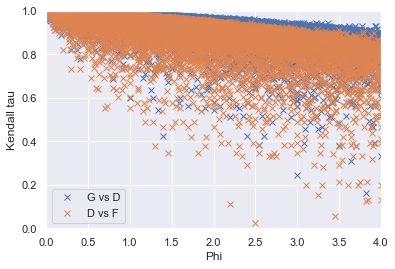

In [3]:
_phi = []
_corr = []
_corr_df = []
for n in tqdm(range(10, 200)):
    for N in range(0, 200):
        g = rk.generator.SwapGenerator()
        g.fit(n)
        _phi.append(N/n)
        _corr.append(rk.corr(g.sample(), g.sample(N=N), method='kendalltau'))
        _corr_df.append(rk.corr(g.sample(N=N), g.sample(N=N), method='kendalltau'))

# PLOT
plt.plot(_phi, _corr, 'x', label='G vs D')
plt.plot(_phi, _corr_df, 'x', label='D vs F')
plt.xlim((0, 4))
plt.ylim((0, 1))
plt.xlabel('Phi')
plt.ylabel('Kendall tau')
plt.legend()
plt.show()

n = 50


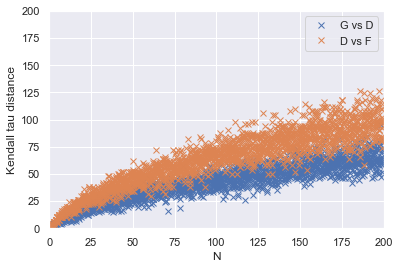

In [20]:
print('n = 50')
_phi = []
_corr = []
_corr_df = []
n = 50
_N = []
_log = []
for N in range(0, 200):
    for _ in range(10): # re-runs
        g = rk.generator.SwapGenerator()
        g.fit(n)
        _N.append(N)
        _corr.append(rk.kendall_tau_distance(g.sample(), g.sample(N=N)))
        _corr_df.append(rk.kendall_tau_distance(g.sample(N=N), g.sample(N=N)))

# PLOT
plt.plot(_N, _corr, 'x', label='G vs D')
plt.plot(_N, _corr_df, 'x', label='D vs F')
plt.xlim((0, 200))
plt.ylim((0, 200))
plt.xlabel('N')
plt.ylabel('Kendall tau distance')
plt.legend()
plt.show()

<a id='part2'></a>
# 2. Real data

The following code defines experiments with real data for sections [2.1](#partA) and [2.2](#partB) of the notebook.

In [3]:
def evaluate_acc_real(M, trials=200, ranks=False, return_d=False):
    """ Evaluate accuracy and score of top-k method on real data.
    
    From a matrix of scores M (rows are candidates, columns are judges).
    Bootstrap (shuffle), then split in 3 and compute the acc/score.
    Same code for 2. and 3.
    
    If return_d, estimate the normalized tau distance between D and F and return it
    """
    M = np.array(M)
    n, m = M.shape # n candidates (rows), m judges (columns)
    tr_scores, te_scores = np.zeros(n), np.zeros(n) # meta-train/test scores
    tr_ranks, te_ranks = np.zeros(n), np.zeros(n) # meta-train/test ranks
    d = 0 # kendall distance
    th = int(m/3)
    for _ in range(trials):
        _M = rk.bootstrap(M, axis=1) # shuffle judges
        D, F, P = _M[:,:th], _M[:,th:2*th], _M[:,2*th:] # dev, final, post
        if ranks: # this way the average score will be the aveage rank instead
            D, F, P = ((rk.rank(D, reverse=True) - 1) / (n-1), 
                       (rk.rank(F, reverse=True) - 1) / (n-1), 
                       (rk.rank(P, reverse=True) - 1) / (n-1))
        D, F, P = rk.score(D), rk.score(F), rk.score(P) # average
        F_rank, P_rank = rk.rank(F), rk.rank(P) # to compute rank errors later
        if return_d:
            d += rk.kendall_tau_distance(D, F, normalize=True)
        for k in range(1, n+1):
            top_k = rk.select_k_best(D, k=k) # list of k best in D
            winner = rk.top_k_method(D, F, k=k) # index of winner selected
            # train score: best of F[top_k], score or average rank score
            tr_scores[k-1] += np.max(F[top_k])
            # test score: score of the selected winner in P
            te_scores[k-1] += P[winner]
            # train rank: normalized rank of the winner in F
            tr_ranks[k-1] += (F_rank[winner] - 1) / (n-1)
            # test rank: normalized rank of the winner in P
            te_ranks[k-1] += (P_rank[winner] - 1) / (n-1)
            #accs[k-1] += (winner == P[0]) # +1 if top-k worked
    if return_d:
        return (tr_scores / trials), (te_scores / trials), (tr_ranks / trials), (te_ranks / trials), (d / trials)
    return (tr_scores / trials), (te_scores / trials), (tr_ranks / trials), (te_ranks / trials)

In [4]:
def experiment(data, trials=200, ranks=False, show_score_plot=False):
    """ Run experiments on real data.
    
    If ranks = True, judges are converted to rank (useful when judges are datasets)
    """
    # Top-k scores
    _k = range(1, data.shape[0]+1)
    tr, te, trr, ter, d = evaluate_acc_real(data, ranks=ranks, trials=trials, return_d=True)
    
    # Plot RANKS
    plt.plot(_k, trr, 'o-', label='Meta-train', color='tab:red')
    plt.plot(_k, ter, 'o-', label='Meta-test', color='tab:blue')
    plt.plot(_k, np.abs(trr - ter), 'o-', label='Generalization gap', color='tab:green')
    plt.xlabel('k')
    plt.ylabel('Rank error')
    plt.legend(loc='center right')
    plt.show()
    print('d = {}'.format(d))
    
    # Plot SCORES
    if show_score_plot:
        plt.plot(_k, tr, 'o-', label='Meta-train', color='tab:red')
        plt.plot(_k, te, 'o-', label='Meta-test', color='tab:blue')
        plt.xlabel('k')
        plt.ylabel('Average score')
        plt.legend(loc='center right')
        plt.show()
        print('d = {}'.format(d))

<a id='partA'></a>
# 2.1. One task case

##### Evaluate select-K-best on various 1 task problems

TODO

- All datasets in one plot
- AutoDL benchmark data too (light version)
- Use the validation data instead of test for the development phase?
- Accuracy of selecting the post-challenge winner (instead of score, and compare both)

In [6]:
def create_score_matrix(dataset, path, reference, candidates, metric):
    # Create matrix
    M = []
    ref_file = os.path.join(path, reference, dataset+'_test.solution')
    ref = pd.read_csv(ref_file, sep=" ", header=None)
    ref = ref.drop([ref.columns[-1]], axis=1) # fix problem in format
    # Development, Final and Post-challenge phases
    for candidate in candidates:
        files = glob(os.path.join(path, candidate, dataset+'_test*.predict'))
        pred_file = sorted(files)[-1] # last predictions
        pred = pd.read_csv(pred_file, sep=" ", header=None)
        pred = pred.drop([pred.columns[-1]], axis=1)  
        l = [rk.metric([ref.loc[i]], [pred.loc[i]], method=metric) for i in range(ref.shape[0])] # DIRTY
        M.append(l)
    M = pd.DataFrame(M)
    M.index = candidates
    return M

In [12]:
path = 'data/automl_predictions'
reference = 'reference'
candidates = ['aad_freiburg', 'gaussian_nb_default', 'abhishek', 'jameslloyd',
              'rf_autosklearn', 'asml_intel', 'knn_autosklearn', 'rf_default',
              'baseline', 'knn_default', 'sgd_autosklearn', 'lise_sun', 'sgd_default', 'djajetic', 'marc_boulle', 'gaussian_nb_autosklearn']
# 'bayesian_ridge_default'
datasets = ['fabert', 'adult', 'alexis', 'arturo', 'digits']
metric = 'accuracy'

fabert


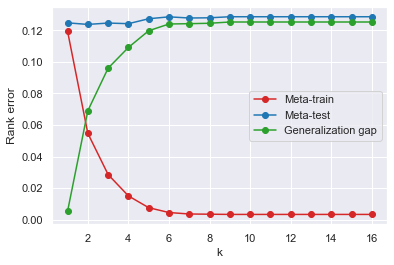

d = 2.45175
adult


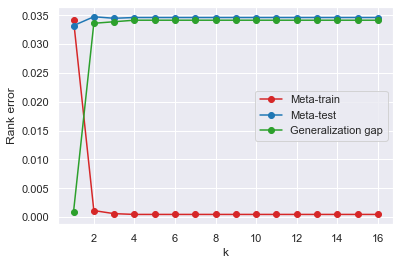

d = 1.6225
alexis


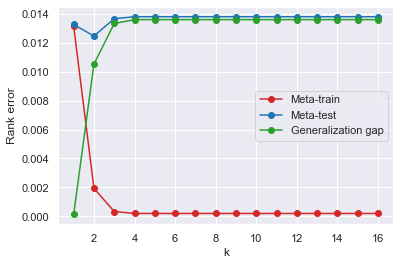

d = 2.115875
arturo


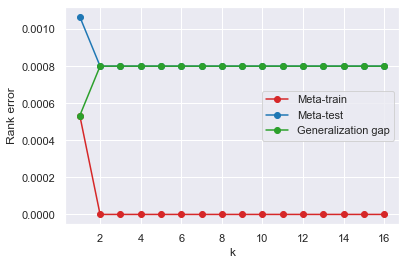

d = 1.28475
digits


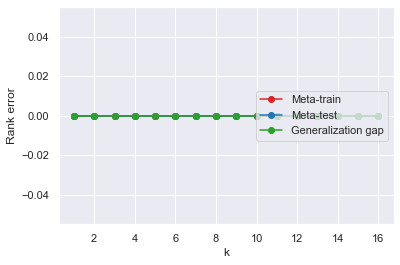

d = 0.011875


In [16]:
#dataset = datasets[0]
for dataset in datasets:
    print(dataset)
    data = create_score_matrix(dataset, path, reference, candidates, metric)
    experiment(data, trials=500, ranks=False, show_score_plot=False)

<a id='partB'></a>
# 2.2 Multi-task (AutoML) case

TODO: 
- Include many benchmarks
- Compare with theoretical approximation
- Compute accuracy
- Error bars
- Not normalized rank error? Maybe easier to interpret

In [9]:
benchmarks = ['AutoDL-AUC.data', 'AutoML.data', 'Statlog.data', 'OpenML.data']
path = 'data/benchmarks'

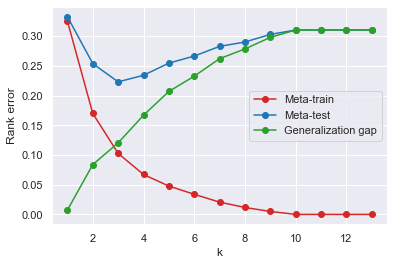

d = 2.3576923076923095


In [10]:
# AutoDL
data = pd.read_csv(os.path.join(path, benchmarks[0]), header=None, sep=' ').T
experiment(data, trials=500)

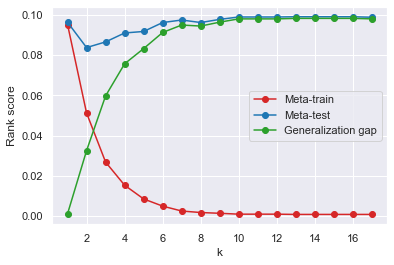

d = 3.0174117647058796


In [89]:
# AutoML
data = pd.read_csv(os.path.join(path, benchmarks[1]), header=None, sep=' ').T
experiment(data, trials=500)

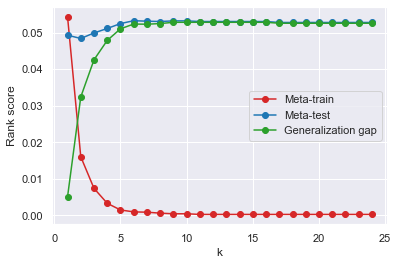

d = 5.712833333333333


In [90]:
# Statlog
data = pd.read_csv(os.path.join(path, benchmarks[2]), header=None, sep=' ').T
experiment(data, trials=500)

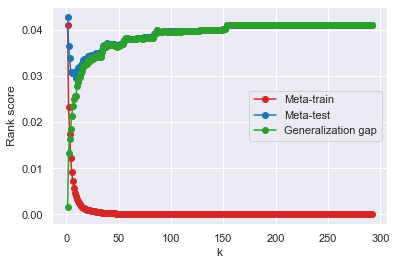

d = 69.04709589041097


In [92]:
# OpenML
data = pd.read_csv(os.path.join(path, benchmarks[3]), header=None, sep=' ').T
experiment(data, trials=500)

#### Estimation of $\phi = \frac{s}{n}$ on real data